- **Filename**: `phase_2_ce+rl_final_model.py`
- **Purpose**: This script trains a ViT5-based Text-to-SQL model using a hybrid loss strategy that combines Cross-Entropy (CE) loss and Reinforcement Learning (RL) reward-based loss.
- **Phase**: Phase 2 of the project – fine-tuning with CE + RL loss.
- **Dataset**: Trains on `train_text2sql.json`, validates on `val_text2sql.json`, evaluates on `test_text2sql.json`.
- **Key Features**:
  - Loads model checkpoint from Phase 1 (`model/Phase1_CEonly`) with pre-resized embeddings.
  - Tokenizes input as natural language question + schema → SQL.
  - Uses `HybridTrainer`, a custom HuggingFace `Trainer` subclass:
    - Starts with CE loss, then blends with reward loss from epoch 2.
    - Hybrid loss = `alpha * CE + beta * (1 - reward)` with default α = 0.7, β = 0.3.
  - Reward computed using a logic-aware scoring function (`reward_fn_v3`) that checks:
    - Correct fields, operators, and values in SQL.
    - Fuzzy string similarity.
  - Includes:
    - Logging callback for printing and saving loss/reward.
    - Callback to clean intermediate checkpoints.
    - Reward tracking at epoch level.

- **Output**:
  - Final model saved at `model/Final_model`.
  - Training logs saved to CSV (`training_log_phase2.csv`).

- **Evaluation**:
  - Generates SQL from test set and prints predictions vs. gold SQL.

- **Requirements**:
  - Python 3.x, HuggingFace Transformers, Datasets, Unidecode, Matplotlib.

- **Usage**:
  - Run directly in a Colab notebook or Python environment with GPU support.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change to project directory
%cd /content/drive/MyDrive/Dự án - báo cáo/Do_an_HK3_DT2210L_Text_To_SQL/ver3/vi_t5_text2sql

/content/drive/MyDrive/Dự án - báo cáo/Do_an_HK3_DT2210L_Text_To_SQL/ver3/vi_t5_text2sql


In [ ]:
!pip install transformers datasets sentencepiece evaluate sacrebleu -q
!pip install Unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.


In [ ]:
# ======== Import Core Python Libraries ========
import os
import re
import csv
import json
import shutil
from collections import Counter
from difflib import SequenceMatcher

# ======== Import Third-party Libraries ========
import torch
import numpy as np
import sqlparse
from datasets import Dataset as HFDataset

# ======== Import Hugging Face Transformers ========
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    DataCollatorForSeq2Seq,
    Trainer,
    TrainerCallback,
    EarlyStoppingCallback
)
from transformers.utils import logging

# ======== Suppress Warnings & Configure Env ========
logging.set_verbosity_error()
os.environ["TRANSFORMERS_NO_TQDM"] = "1"

In [ ]:

# =================== CONFIG =====================
output_dir = "model/save_training" # Save training new model
save_dir = "model/Final_model" # Save new model training final
logs = "model/logs"
# ==================== LOAD PHASE 1 CHECKPOINT =====================
checkpoint_path = "model/Phase1_CEonly"  # Phase 1 model and tokenizer path

# ======  Load processed JSON (train/val/test) ======

with open("data/processing/phase3/train_text2sql.json", "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open("data/processing/phase3/val_text2sql.json", "r", encoding="utf-8") as f:
    val_data = json.load(f)

# ======  Convert to HuggingFace Datasets ======
train_dataset = HFDataset.from_list([
    {
        "input": f"Câu hỏi: {item['Question']} | Schema: {item['Schema']}",
        "output": item['SQL']
    } for item in train_data
])

val_dataset = HFDataset.from_list([
    {
        "input": f"Câu hỏi: {item['Question']} | Schema: {item['Schema']}",
        "output": item['SQL']
    } for item in val_data
])
print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))

# ====== 3. Print one sample from each dataset ======
print("\n--- Một mẫu từ tập huấn luyện ---")
print(train_dataset[0])

print("\n--- Một mẫu từ tập kiểm định ---")
print(val_dataset[0])


Train samples: 12750
Validation samples: 1500

--- Một mẫu từ tập huấn luyện ---
{'input': 'Câu hỏi: Nhà nào có nội thất cơ bản? | Schema: furniture_state[str], price[float]', 'output': "SELECT * FROM price_house WHERE furniture_state = 'Nội thất cơ bản'"}

--- Một mẫu từ tập kiểm định ---
{'input': 'Câu hỏi: Liệt kê các nhà có mặt tiền là 4m | Schema: frontage[float], price[float]', 'output': 'SELECT * FROM price_house WHERE frontage = 4'}


In [ ]:
# Load tokenizer + model from checkpoint Phase 1
tokenizer = T5Tokenizer.from_pretrained(checkpoint_path)
model = T5ForConditionalGeneration.from_pretrained(checkpoint_path)
model.resize_token_embeddings(len(tokenizer))
model.config.decoder_start_token_id = model.config.eos_token_id

# Tokenization function
def tokenize_fn(example):
    """
    Tokenizes input-output pairs for sequence-to-sequence training.

    Converts natural language question + schema into token IDs, and prepares the label sequence
    for teacher forcing. Padding tokens in the target are masked with -100 for loss computation.

    Args:
        example (dict): A dictionary with "input" (question + schema) and "output" (SQL).

    Returns:
        dict: A dictionary containing input IDs, attention mask, and masked labels.
    """
    inputs = tokenizer(example["input"], max_length=512, truncation=True, padding="max_length")
    targets = tokenizer(example["output"], max_length=128, truncation=True, padding="max_length")
    inputs["labels"] = [l if l != tokenizer.pad_token_id else -100 for l in targets["input_ids"]]
    return inputs

# Re-tokenize with cache disabled to sync tokenizer
tokenized_train = train_dataset.map(tokenize_fn, batched=True, load_from_cache_file=False)
tokenized_val = val_dataset.map(tokenize_fn, batched=True, load_from_cache_file=False)


Map:   0%|          | 0/12750 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Số lượng mẫu: 12750
Max length: 58 tokens
Mean length: 26.05 tokens
95th percentile: 47.0 tokens
99th percentile: 55.0 tokens


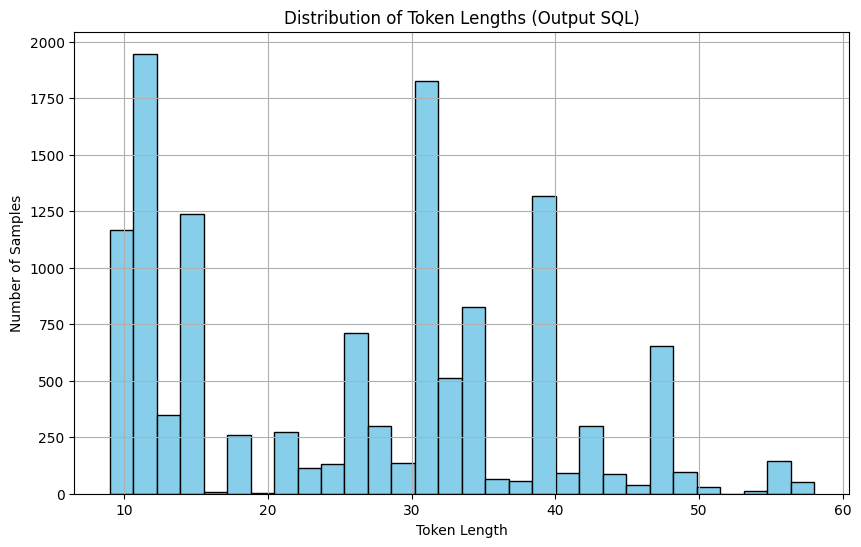

In [ ]:
import matplotlib.pyplot as plt
# ==================== Analyze output length =====================

# 1. Collect all output sentences (the target texts).
outputs = [ex["output"] for ex in train_dataset]

# 2. Tokenize them without padding or truncation (padding=False, truncation=False).
tokenized_outputs = tokenizer(outputs, padding=False, truncation=False)

# 3. Calculate the length (number of tokens) for each tokenized output.
token_lengths = [len(ids) for ids in tokenized_outputs["input_ids"]]

print(f"Số lượng mẫu: {len(token_lengths)}")
print(f"Max length: {np.max(token_lengths)} tokens")
print(f"Mean length: {np.mean(token_lengths):.2f} tokens")
print(f"95th percentile: {np.percentile(token_lengths, 95)} tokens")
print(f"99th percentile: {np.percentile(token_lengths, 99)} tokens")

# 4. Plot a histogram if needed.
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=30, edgecolor="black", color="skyblue")
plt.xlabel('Token Length')
plt.ylabel('Number of Samples')
plt.title('Distribution of Token Lengths (Output SQL)')
plt.grid(True)
plt.show()

In [ ]:
import re
from collections import Counter
from difflib import SequenceMatcher
import sqlparse

def extract_where_conditions(sql: str) -> list:
    """
    Extracts individual condition strings from the WHERE clause of a SQL query.
    This is a basic split by 'AND' (ignores parentheses or 'OR').

    Args:
        sql (str): SQL query.

    Returns:
        list: A list of condition strings.
    """
    sql = sql.lower()
    match = re.search(r"where (.+)", sql)
    if not match:
        return []
    where_clause = match.group(1)
    conditions = [cond.strip() for cond in where_clause.split("and")]
    return conditions

def strip_location_conditions(conditions: list) -> list:
    """
    Removes location-related conditions (city, district, ward) from a list of conditions.

    Args:
        conditions (list): List of SQL condition strings.

    Returns:
        list: Filtered list excluding location fields.
    """
    return [
        c for c in conditions
        if not any(loc in c for loc in ['city', 'district', 'ward'])
    ]

def extract_conditions(sql: str):
    """
    Extracts (field, operator, value) tuples from the WHERE clause of SQL.
    """
    try:
        sql = sql.lower()
        conditions = []
        where_match = re.search(r"where\s+(.*)", sql)
        if where_match:
            clause = where_match.group(1)
            clause = re.split(r'\s+and\s+|\s+or\s+', clause)
            for cond in clause:
                cond = cond.strip()
                match = re.match(r"(\w+)\s*(=|>=|<=|<|>|like|between)\s*(.+)", cond)
                if match:
                    field, op, val = match.groups()
                    val = val.strip().strip("'").strip('"')
                    conditions.append((field.strip(), op.strip(), val))
        return conditions
    except:
        return []

def reward_fn_v3(pred_sql: str, gold_sql: str) -> float:
    """
    Computes a logic-aware reward score between predicted and gold SQL queries.

    This version penalizes:
    - wrong field (no match in any condition)
    - wrong operator
    - wrong value (based on fuzzy match)
    - adds fuzzy string similarity for overall structure

    Args:
        pred_sql (str): Predicted SQL string
        gold_sql (str): Ground truth SQL string

    Returns:
        float: Reward in [0.0, 1.0]
    """
    try:
        pred = pred_sql.strip().lower()
        gold = gold_sql.strip().lower()

        if pred == gold:
            return 1.0

        # Fuzzy string similarity
        fuzzy = SequenceMatcher(None, pred, gold).ratio()

        # Parse WHERE clause
        pred_conds = extract_conditions(pred)
        gold_conds = extract_conditions(gold)

        if not gold_conds:
            return fuzzy  # fallback if no WHERE clause

        matched_fields = 0
        matched_ops = 0
        matched_vals = 0
        total = len(gold_conds)
        unmatched_fields = 0

        for gold_field, gold_op, gold_val in gold_conds:
            matched = False
            for pred_field, pred_op, pred_val in pred_conds:
                if gold_field == pred_field:
                    matched_fields += 1
                    if gold_op == pred_op:
                        matched_ops += 1
                    val_sim = SequenceMatcher(None, pred_val, gold_val).ratio()
                    if val_sim > 0.9 or gold_val == pred_val:
                        matched_vals += 1
                    matched = True
                    break
            if not matched:
                unmatched_fields += 1

        # Scores
        field_score = matched_fields / total
        op_score = matched_ops / total
        val_score = matched_vals / total
        field_miss_penalty = 0.15 * unmatched_fields  # strong penalty for missing fields

        reward = (
            0.4 * field_score +
            0.2 * op_score +
            0.2 * val_score +
            0.2 * fuzzy -
            field_miss_penalty
        )
        return round(max(0.0, min(reward, 1.0)), 4)

    except Exception as e:
        print(f"[Reward Error] {e}")
        return 0.0

pred_sql = "SELECT * FROM price_house WHERE price >= 9900000000 AND price <= 10000000000 AND district = 'Đống Đa' AND city = 'Hà Nội'"
gold_sql = "SELECT * FROM price_house WHERE price >= 9900000000 AND price <= 10000000000 AND district = 'Đống Đa' AND city = 'Hà Nội'"

score = reward_fn_v3(pred_sql, gold_sql)
print(f"Reward score: {score}")

Reward score: 1.0


In [ ]:
class AggressiveCheckpointCleanerCallback(TrainerCallback):
    """
    A callback that aggressively deletes old model checkpoints during training.
    - Keeps only the most recent checkpoint at each save step.
    - Removes all checkpoints at the end of training to save disk space.
    Useful for reducing disk usage when frequent checkpointing is enabled.
    """
    def on_save(self, args, state, control, **kwargs):
        """
        Deletes all but the latest model checkpoint after each save step.
        This helps reduce disk space usage by keeping only the most recent checkpoint during training.
        """
        output_dir = args.output_dir
        checkpoints = sorted(
            [d for d in os.listdir(output_dir) if d.startswith("checkpoint-")],
            key=lambda x: int(x.split("-")[-1])
        )
        for ckpt in checkpoints[:-1]:
            shutil.rmtree(os.path.join(output_dir, ckpt), ignore_errors=True)

    def on_train_end(self, args, state, control, **kwargs):
        """
        Removes all remaining checkpoints at the end of training.
        Ensures that only the final trained model is kept to minimize storage use.
        """
        output_dir = args.output_dir
        for ckpt in os.listdir(output_dir):
            if ckpt.startswith("checkpoint-"):
                shutil.rmtree(os.path.join(output_dir, ckpt), ignore_errors=True)

class LogLossToCSVCallback(TrainerCallback):
    """
    Logs CE loss, reward, and hybrid loss at each logging step to a CSV file.

    Creates the CSV file with headers on the first log, then appends one row per step.
    Skips logging if required fields are missing in `logs`.
    """
    def __init__(self, log_path="loss_log.csv"):
        """
        Initializes the callback with the path to the CSV log file.

        Args:
            log_path (str): Path to the CSV file where logs will be written.
        """
        self.log_path = log_path
        self.header_written = False

    def on_log(self, args, state, control, logs=None, **kwargs):
        """
        Writes training step metrics (CE loss, reward, hybrid loss) to a CSV file.
        Creates the header row if the file does not exist, and appends a new row for each log step.
        Skips logging if 'loss' is missing from the logs.
        """
        if not logs or "loss" not in logs:
            return

        if not self.header_written:
            with open(self.log_path, "w", newline="") as f:
                csv.writer(f).writerow(["step", "ce_loss", "reward", "hybrid_loss"])
            self.header_written = True

        with open(self.log_path, "a", newline="") as f:
            csv.writer(f).writerow([
                state.global_step,
                logs.get("loss"),
                logs.get("reward"),
                logs.get("hybrid_loss")
            ])

class EpochRewardLoggerCallback(TrainerCallback):
    """Logs the average reward score at the end of each training epoch."""
    def __init__(self):
        """Initializes a list to accumulate reward values across training steps."""
        self.epoch_rewards = []

    def on_step_end(self, args, state, control, **kwargs):
        """Appends reward value from current step (if available) to epoch reward list."""
        reward = kwargs.get("logs", {}).get("reward")
        if reward is not None:
            self.epoch_rewards.append(reward)

    def on_epoch_end(self, args, state, control, **kwargs):
        """Computes and prints average reward at the end of the epoch.
        Resets the reward list for the next epoch.
        """
        if self.epoch_rewards:
            avg = np.mean(self.epoch_rewards)
            print(f"\n[Epoch {state.epoch:.2f}] Avg reward: {avg:.4f}")
            self.epoch_rewards = []


In [ ]:
class HybridTrainer(Trainer):
    """Custom trainer that combines cross-entropy loss with a logic-based reward loss."""

    def __init__(self, reward_fn, tokenizer, reward_fn_simple=None,
                 hybrid_start_epoch=1, alpha=0.7, beta=0.3, *args, **kwargs):
        """Initializes hybrid trainer with reward function and loss weights.
        Args:
            reward_fn (callable): Computes logic-aware reward between prediction and gold.
            tokenizer (PreTrainedTokenizer): Tokenizer for decoding sequences.
            reward_fn_simple (callable, optional): Fallback reward function.
            hybrid_start_epoch (int): Epoch to start applying reward-based loss.
            alpha (float): Weight for CE loss.
            beta (float): Weight for reward loss.
        """
        kwargs.pop("tokenizer", None)
        super().__init__(*args, **kwargs)

        self.tokenizer = tokenizer
        self.reward_fn = reward_fn
        self.reward_fn_simple = reward_fn_simple
        self.hybrid_start_epoch = hybrid_start_epoch
        self.alpha = alpha
        self.beta = beta

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """Computes hybrid loss: CE + reward-based loss.
        Uses CE loss before hybrid_start_epoch, then combines CE and reward losses.
        Logs CE loss, reward score, and hybrid loss at each step.
        """
        outputs = model(**inputs)
        ce_loss = outputs.loss

        epoch = self.state.epoch or 0
        if epoch < self.hybrid_start_epoch:
            return (ce_loss, outputs) if return_outputs else ce_loss

        generated_tokens = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=64,
            decoder_start_token_id=model.config.decoder_start_token_id,
            pad_token_id=self.tokenizer.pad_token_id
        )

        preds = self.tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        labels = inputs["labels"]
        golds = self.tokenizer.batch_decode(labels, skip_special_tokens=True)

        rewards = []
        for pred, gold in zip(preds, golds):
            try:
                rewards.append(self.reward_fn(pred, gold))
            except:
                rewards.append(0.0)

        avg_reward = sum(rewards) / len(rewards) if rewards else 0.0
        reward_loss = 1.0 - avg_reward
        hybrid_loss = self.alpha * ce_loss + self.beta * reward_loss
        print(f"[Hybrid] Step {self.state.global_step} | CE: {ce_loss.item():.4f} | Reward: {avg_reward:.4f} | Hybrid: {hybrid_loss.item():.4f}")

        self.log({
            "ce_loss": ce_loss.item(),
            "reward": avg_reward,
            "hybrid_loss": hybrid_loss.item()
        })

        return (hybrid_loss, outputs) if return_outputs else hybrid_loss

def reward_fn_simple(pred: str, gold: str) -> float:
    """Returns a fuzzy string similarity score between prediction and gold SQL."""
    from difflib import SequenceMatcher
    return SequenceMatcher(None, pred.strip().lower(), gold.strip().lower()).ratio()


In [ ]:
# ======== CALLBACK LOG LOSS ========
class PrintLossCallback(EarlyStoppingCallback):
    """Callback that prints loss and eval loss at each logging step."""
    def on_log(self, args, state, control, logs=None, **kwargs):
        """Prints step number, training loss, and evaluation loss (if available) to console."""
        if logs is not None and "loss" in logs:
            step = state.global_step
            print(f"Step {step:<5} | Loss: {logs['loss']:<8.4f} | Eval Loss: {logs.get('eval_loss', '---')}")

# ======== SETUP TRAINING ========
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=2e-4,
    num_train_epochs=4,
    save_strategy="epoch",
    eval_strategy="epoch",
    save_steps=300,
    eval_steps=300,
    logging_steps=100,
    save_total_limit=2,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

log_path = os.path.join(logs, "training_log_phase2.csv")
trainer = HybridTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
    tokenizer=tokenizer,
    reward_fn=reward_fn_v3,
    reward_fn_simple=reward_fn_simple,
    hybrid_start_epoch=2,
    alpha=0.7,
    beta=0.3,
    callbacks=[
        PrintLossCallback(),
        #EarlyStoppingCallback(early_stopping_patience=3),
        AggressiveCheckpointCleanerCallback(),
        LogLossToCSVCallback(log_path=log_path),
        EpochRewardLoggerCallback()
    ],
)

# ======== Training ========
trainer.train()

# ======== Save model ========
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)


Step 100   | Loss: 0.0153   | Eval Loss: ---
{'loss': 0.0153, 'grad_norm': 0.07287122309207916, 'learning_rate': 0.00019751568381430365, 'epoch': 0.12547051442910917}
Step 200   | Loss: 0.0145   | Eval Loss: ---
{'loss': 0.0145, 'grad_norm': 0.10055390000343323, 'learning_rate': 0.00019500627352572148, 'epoch': 0.25094102885821834}
Step 300   | Loss: 0.0137   | Eval Loss: ---
{'loss': 0.0137, 'grad_norm': 0.6678731441497803, 'learning_rate': 0.0001924968632371393, 'epoch': 0.37641154328732745}
Step 400   | Loss: 0.0142   | Eval Loss: ---
{'loss': 0.0142, 'grad_norm': 0.015193839557468891, 'learning_rate': 0.00018998745294855707, 'epoch': 0.5018820577164367}
Step 500   | Loss: 0.0116   | Eval Loss: ---
{'loss': 0.0116, 'grad_norm': 0.07995805889368057, 'learning_rate': 0.0001874780426599749, 'epoch': 0.6273525721455459}
Step 600   | Loss: 0.0111   | Eval Loss: ---
{'loss': 0.0111, 'grad_norm': 0.02327604591846466, 'learning_rate': 0.00018496863237139273, 'epoch': 0.7528230865746549}
Ste

('model/P3-CE+RL/tokenizer_config.json',
 'model/P3-CE+RL/special_tokens_map.json',
 'model/P3-CE+RL/spiece.model',
 'model/P3-CE+RL/added_tokens.json')

In [ ]:
# ======== Path Configuration ========
model_dir = "model/Final_model"
test_path = "data/processing/phase3/test_text2sql.json"

# ======== Load Model & Tokenizer ========
tokenizer = T5Tokenizer.from_pretrained(model_dir)
model = T5ForConditionalGeneration.from_pretrained(model_dir)
model.eval().to("cuda")

# ======== Preprocessing ========
def clean_user_question(text: str) -> str:
    return text.lower().strip()

# ======== Generate SQL Query ========
def generate_sql(question: str, schema: str, max_len: int = 128) -> str:
    input_text = f"Câu hỏi: {clean_user_question(question)} | Schema: {schema}"
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True).to(model.device)
    outputs = model.generate(
        inputs.input_ids,
        max_length=max_len,
        num_beams=1,
        early_stopping=False,
        decoder_start_token_id=model.config.decoder_start_token_id,
        pad_token_id=tokenizer.pad_token_id
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# ======== Evaluate the Entire Test Set ========
def evaluate_test_set():
    with open(test_path, "r", encoding="utf-8") as f:
        test_data = json.load(f)

    print(f"Total test samples: {len(test_data)}\n")

    for i, item in enumerate(test_data):
        question = item["Question"]
        schema = item["Schema"]
        gold_sql = item["SQL"]

        # Step 1: Model generate
        raw_pred_sql = generate_sql(question, schema)

        # Output
        print(f"========== Sample {i + 1} ==========")
        print(f"Question: {question}")
        print(f"Predicted SQL:\n{raw_pred_sql}")
        print(f"Gold SQL:\n{gold_sql}\n")

# ======== Run Evaluation ========
if __name__ == "__main__":
    evaluate_test_set()


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Predicted SQL (final with fixed location):
SELECT * FROM price_house WHERE price < 9000000000 AND area < 65    AND ward = 'Thạnh Xuân' AND district = 'Quận 12' AND city = 'Hồ Chí Minh'
Gold SQL:
SELECT * FROM price_house WHERE price < 9000000000 AND area < 65 AND ward = 'Khương Mai' AND district = 'Thanh Xuân' AND city = 'Hà Nội'

========== Sample 196 ==========
Question: Có nhà nào ở phường La Khê, quận Hà Đông, Hà Nội có giá khoảng 7,5 tỷ không?
Predicted SQL (raw):
SELECT * FROM price_house WHERE price = 7500000000 AND ward = 'La Khê' AND district = 'Hà Đông' AND city = 'Hà Nội'
Predicted SQL (final with fixed location):
SELECT * FROM price_house WHERE price = 7500000000    AND ward = 'La Khê' AND district = 'Hà Đông' AND city = 'Hà Nội'
Gold SQL:
SELECT * FROM price_house WHERE price = 7500000000 AND ward = 'La Khê' AND district = 'Hà Đông' AND city = 'Hà Nội'

========== Sample 197 ==========
Question: Tôi đang tìm nhà khoả